El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_3376600/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

CUTOFF_DATE_STR = ... # Not used

In [3]:
# Parameters
ORG_NAME = "Index Coop"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "2d"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-08 10:00"
CUTOFF_DATE_STR = None


# Load data

In [4]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

,platform,name,id,proposal,deployment,platform_vote,voter,date,choice,weight
0,snapshot,Index Coop,e976da29-a2a3-595e-a7ae-f0b264b3a9f1,ff818a67-b9a9-5752-a6fc-775ebbaf5495,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,0x0b071378b68359871ce370c9368f2e2b61e5cb74bc32...,0x97a1ca841b4792068932d4224681f6f6fa22c549,2023-07-13 00:13:46,"[4.092668814653204, 0, 0]",4.0
1,snapshot,Index Coop,5034c907-d382-5b36-a160-2a8797c0de4c,68ae729a-bcb2-525a-b696-28409badb9fa,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,0x767150278ccaeae179e3adb3c655c26c4f3351e9dbbb...,0x8d5237037a590a2db531f3cfb8f42605cf306f34,2022-11-08 14:56:08,"[0.6508696852821667, 6.094062445932905]",6.0
2,snapshot,Index Coop,4ce11073-5933-5912-88b7-2cb24d26f161,68ae729a-bcb2-525a-b696-28409badb9fa,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,0x8f2b128fc2cb5f6cff4b20de4e7785d7cc1a09d9ee73...,0x03dce5fa9e968ffb6b64e781d11422228c86c368,2022-11-08 10:08:06,"[18085.11991562141, 0]",18085.0
3,snapshot,Index Coop,8943a8f8-3183-5174-933d-3a9091ea6b95,68ae729a-bcb2-525a-b696-28409badb9fa,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,0x865fca0b19198d5ce59febf3017748be0ba8fb311157...,0x03f623de8464124feff439a6bdb3f9793b6ed34c,2022-11-08 10:04:30,"[0, 75000]",75000.0
4,snapshot,Index Coop,1ca78b0e-652e-5475-b203-bc629bcd9345,68ae729a-bcb2-525a-b696-28409badb9fa,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,0x7a4ac25127d6ff3c6156e675cec48413d5304b9cdeec...,0xff03658e92a9162fe78bd7e8bc5d0aa45739e8bb,2022-11-08 08:31:50,"[30.599377353147386, 0]",30.0
...,...,...,...,...,...,...,...,...,...,...
24026,snapshot,Index Coop,f017fcd4-25e2-5502-8ca4-a292854b1a4b,e92a6af6-5f71-5ea9-afc7-dec56a62a1b3,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,0xf709e3016221d262b45d0ed25d7271f72343c15a9e34...,0x197008a1d3e26a97a19f46c121482969cef95b7d,2023-03-05 23:20:03,"[3, 0, 0]",3.0
24027,snapshot,Index Coop,21d0c951-84bd-532a-b638-7719becc3e88,e92a6af6-5f71-5ea9-afc7-dec56a62a1b3,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,0x34b828ff62c01116ae35a33d94e7a96e9bd93acf6dca...,0xfe8bceb97bdf247de8b6dc1f01cb1af62ca94d46,2023-03-05 15:40:00,"[0.24084970666679617, 0, 0]",0.0
24028,snapshot,Index Coop,aa829353-5f7b-507d-972f-9cf177357217,e92a6af6-5f71-5ea9-afc7-dec56a62a1b3,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,0x2e6a6a5bd703bcedbc44c2517238c98f23cc95807a41...,0x49084125e425ed84a81e97f866043ba413e959b9,2023-03-05 10:15:12,"[25, 0, 0]",25.0
24029,snapshot,Index Coop,8f85d176-fd8f-5bda-9489-ee6bede0302a,e92a6af6-5f71-5ea9-afc7-dec56a62a1b3,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,0xe8afb2a95f4498c25e51ec19244adee09d29c673cfaf...,0x1df6f7c929335b594f06b2d8a7febcf876bb0b25,2023-03-05 06:09:38,"[2, 0, 0]",2.0


Warning, removing 24031 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24031 entries, 0 to 24030
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       24031 non-null  object        
 1   name           24031 non-null  object        
 2   id             24031 non-null  object        
 3   proposal       24031 non-null  category      
 4   deployment     24031 non-null  object        
 5   platform_vote  24031 non-null  object        
 6   voter          24031 non-null  category      
 7   date           24031 non-null  datetime64[ns]
 8   choice         24031 non-null  object        
 9   weight         24031 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 1.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 874 entries, 0 to 873
Data columns (total 13 columns):
 #   Column               Non-Null Cou

In [5]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0x97a1ca841b4792068932d4224681f6f6fa22c549,ff818a67-b9a9-5752-a6fc-775ebbaf5495,2023-07-13 00:13:46,1
1,0x8d5237037a590a2db531f3cfb8f42605cf306f34,68ae729a-bcb2-525a-b696-28409badb9fa,2022-11-08 14:56:08,1
2,0x03dce5fa9e968ffb6b64e781d11422228c86c368,68ae729a-bcb2-525a-b696-28409badb9fa,2022-11-08 10:08:06,1
3,0x03f623de8464124feff439a6bdb3f9793b6ed34c,68ae729a-bcb2-525a-b696-28409badb9fa,2022-11-08 10:04:30,1
4,0xff03658e92a9162fe78bd7e8bc5d0aa45739e8bb,68ae729a-bcb2-525a-b696-28409badb9fa,2022-11-08 08:31:50,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                          874
mean     2 days 20:51:00.808924485
std      1 days 12:19:20.021577041
min                0 days 10:00:00
25%                2 days 00:00:00
50%         2 days 12:21:20.500000
75%                3 days 00:00:00
max               19 days 23:59:31
dtype: object

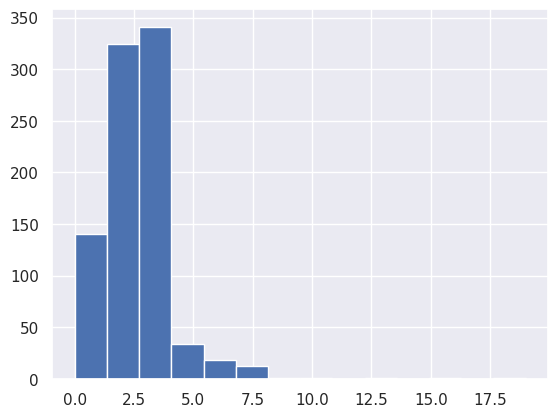

In [6]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

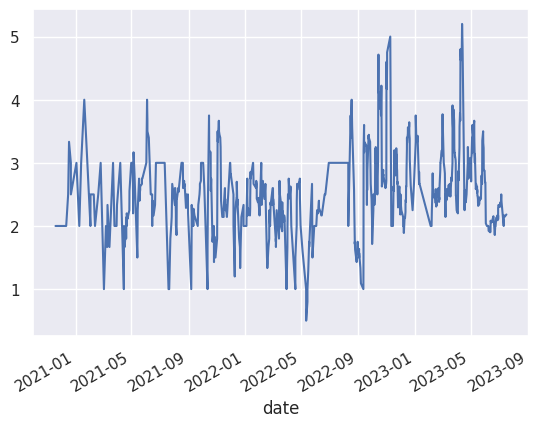

In [7]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Monday       250
Tuesday      173
Wednesday    154
Thursday     118
Friday       101
Saturday      46
Sunday        32
Name: start, dtype: int64

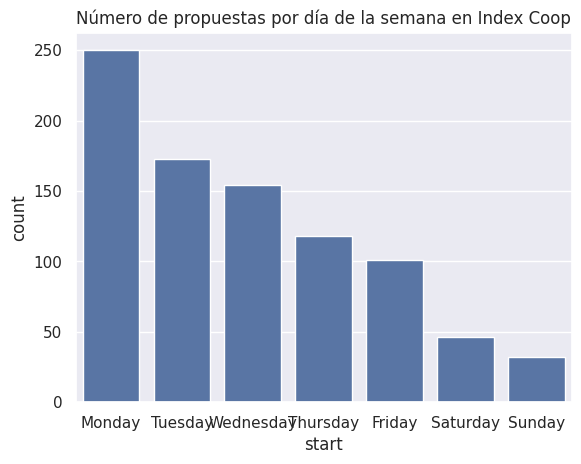

In [8]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Tuesday      6455
Wednesday    4932
Thursday     4115
Monday       3095
Friday       2538
Saturday     1823
Sunday       1073
Name: date, dtype: int64

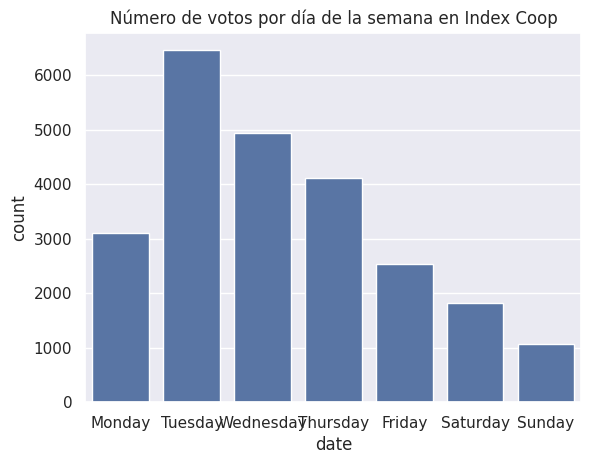

In [9]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

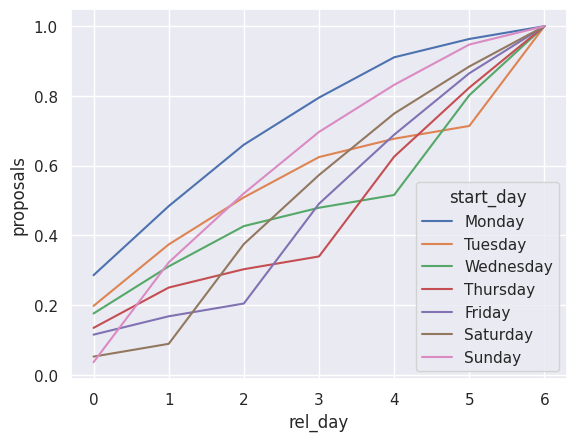

In [10]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

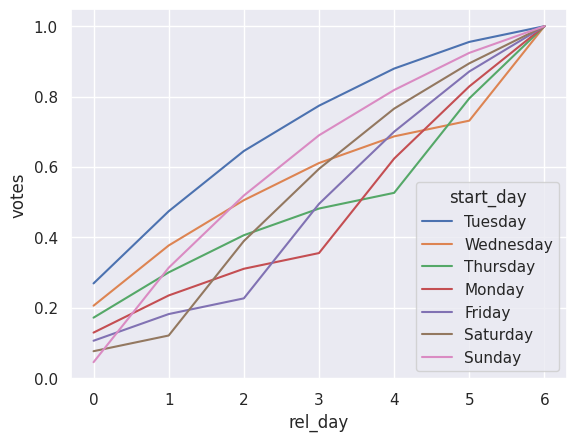

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

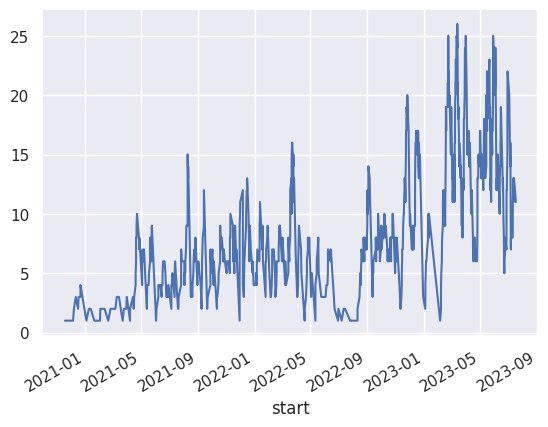

In [12]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [13]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                           W-SUN       W-MON       W-TUE  \
votes in open proposals (train) count  138.000000  138.000000  138.000000   
                                mean    25.608696   18.688406   31.572464   
                                std     34.623403   26.333571   37.921334   
                                min      0.000000    0.000000    0.000000   
                                50%     16.500000    2.000000   20.000000   
                                max    207.000000  130.000000  218.000000   
users in open proposals (train) count  138.000000  138.000000  138.000000   
                                mean    15.289855   12.507246   17.971014   
                                std     18.835517   18.085864   19.684349   
                                min      0.000000    0.000000    0.000000   
                                50%     10.000000    2.000000   15.000000   
                                max    108.000000  118.000000   86.000000   
open proposals                  count  138.000000  138.000000  138.000000   
                                mean     1.826087    1.311594    2.659420   
                                std      2.311233    1.867121    2.681367   
                                min      0.000000    0.000000    0.000000   
                                50%      1.000000    1.000000    2.000000   
                                max     10.000000   11.000000   17.000000   
votes in test                   count  138.000000  138.000000  138.000000   
                                mean    12.927536   12.710145   49.369565   
                                std     16.990610   26.121055   63.567434   
                                min      0.000000    0.000000    0.000000   
                                50%      5.000000    1.500000   28.500000   
                                max     74.000000  258.000000  457.000000   
users in test                   count  138.000000  138.000000  138.000000   
                                mean     8.884058    8.840580   24.318841   
                                std     11.678211   14.444076   24.016717   
                                min      0.000000    0.000000    0.000000   
                                50%      4.500000    1.000000   18.000000   
                                max     46.000000  113.000000   98.000000   
vpp test                        count   85.000000   73.000000  108.000000   
                                mean     8.986555   12.244953   20.388892   
                                std      9.381608   13.754618   16.235584   
                                min      0.000000    0.000000    1.000000   
                                50%      5.833333    7.000000   16.500000   
                                max     37.000000   86.000000   70.000000   
vpu test                        count   77.000000   72.000000  108.000000   
                                mean     1.474280    1.403495    1.863700   
                                std      0.557016    0.553610    0.919029   
                                min      1.000000    1.000000    1.000000   
                                50%      1.333333    1.123810    1.666667   
                                max      3.285714    4.000000    6.555556   

f                                           W-WED       W-THU       W-SAT  
votes in open proposals (train) count  138.000000  138.000000  138.000000  
                                mean    59.050725   78.000000   37.992754  
                                std     68.489791   91.509802   45.659402  
                                min      0.000000    0.000000    0.000000  
                                50%     41.000000   50.000000   25.500000  
                                max    424.000000  570.000000  266.000000  
users in open proposals (train) count  138.000000  138.000000  138.000000  
                                mean    28.094203   36.181159   25.079710  
    

In [14]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_3376600/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),3534.000000,2579.000000,4357.000000,8149.000000,10764.000000,5243.000000
users in open proposals (train),2110.000000,1726.000000,2480.000000,3877.000000,4993.000000,3461.000000
open proposals,252.000000,181.000000,367.000000,482.000000,515.000000,326.000000
votes in test,1784.000000,1754.000000,6813.000000,5632.000000,4731.000000,2672.000000
users in test,1226.000000,1220.000000,3356.000000,2813.000000,2780.000000,1641.000000
vpp test,763.857143,893.881602,2202.000350,1536.757323,1501.820671,1014.819336
vpu test,113.519588,101.051620,201.279557,216.450585,212.600374,159.887745


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [15]:
from src.baseline import getBaselineRecommendations

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

"\ndef getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):\n    bestVotes = train['itemID'].value_counts()\n    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])\n\n    if remove_train:\n        df = filter_by(df, train, ['userID', 'itemID'])\n        \n    df = df.groupby('userID').head(k).reset_index(drop=True)\n\n    df['prediction'] = True\n    return df\n"

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [16]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [17]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [18]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2021-02-13 20:35:46)  =====
Currently open proposals: 1
Train votes in open proposals:  36
Test votes in open proposals:    0

===== Training on fold 1 (t: 2021-05-14 17:31:38)  =====
Currently open proposals: 3
Train votes in open proposals:  30
Test votes in open proposals:  117

===== Training on fold 2 (t: 2021-08-11 03:15:01)  =====
Currently open proposals: 9
Train votes in open proposals: 270
Test votes in open proposals:  182



===== Training on fold 3 (t: 2021-11-07 10:45:33)  =====
Currently open proposals: 2
Train votes in open proposals:  62
Test votes in open proposals:   25

===== Training on fold 4 (t: 2022-02-04 00:20:30)  =====
Currently open proposals: 1
Train votes in open proposals:  53
Test votes in open proposals:    6



===== Training on fold 5 (t: 2022-05-03 10:44:21)  =====
Currently open proposals: 2
Train votes in open proposals:  38
Test votes in open proposals:   49



===== Training on fold 6 (t: 2022-07-28 17:51:11)  =====
Currently open proposals: 1
Train votes in open proposals:  35
Test votes in open proposals:    0

===== Training on fold 7 (t: 2022-10-27 07:28:56)  =====
Currently open proposals: 6
Train votes in open proposals: 153
Test votes in open proposals:   19



===== Training on fold 8 (t: 2023-01-13 20:44:31)  =====
Currently open proposals: 2
Train votes in open proposals:  37
Test votes in open proposals:    0

===== Training on fold 9 (t: 2023-04-22 01:42:11)  =====
Currently open proposals: 5
Train votes in open proposals:  58
Test votes in open proposals:    8


In [19]:
# from src import paths

# Won't even save it because its not used
# pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.231037,0.567361,0.529839,0.632770,0.133572,0.591637,0.551816,0.700000,0.089048,0.591637,0.551816,0.700000,0.257911,0.133572
std,0.176371,0.431049,0.421771,0.470100,0.105475,0.426657,0.416236,0.483046,0.070316,0.426657,0.416236,0.483046,0.198763,0.105475
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050000,0.087617,0.061292,0.106924,0.025000,0.138021,0.098377,0.250000,0.016667,0.138021,0.098377,0.250000,0.050000,0.025000
50%,0.264976,0.790798,0.705779,0.950000,0.151111,0.811367,0.741493,1.000000,0.100741,0.811367,0.741493,1.000000,0.302222,0.151111
75%,0.379124,0.910783,0.877083,1.000000,0.199576,0.910783,0.877083,1.000000,0.133051,0.910783,0.877083,1.000000,0.399153,0.199576
max,0.457143,1.000000,1.000000,1.000000,0.271429,1.000000,1.000000,1.000000,0.180952,1.000000,1.000000,1.000000,0.514286,0.271429


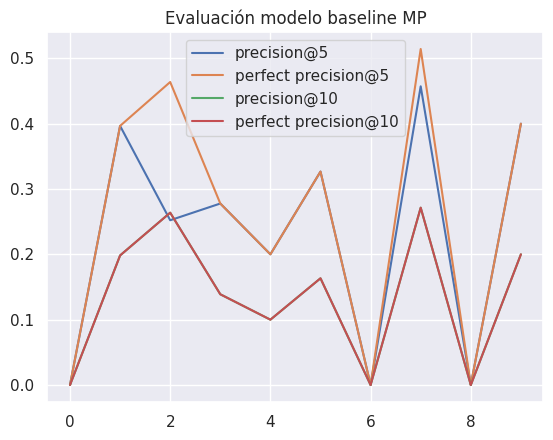

In [20]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.257911,0.700000,0.693915,0.693915,0.133572,0.700000,0.700000,0.700000,0.089048,0.700000,0.700000,0.700000
std,0.198763,0.483046,0.479011,0.479011,0.105475,0.483046,0.483046,0.483046,0.070316,0.483046,0.483046,0.483046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050000,0.250000,0.240741,0.240741,0.025000,0.250000,0.250000,0.250000,0.016667,0.250000,0.250000,0.250000
50%,0.302222,1.000000,0.988095,0.988095,0.151111,1.000000,1.000000,1.000000,0.100741,1.000000,1.000000,1.000000
75%,0.399153,1.000000,1.000000,1.000000,0.199576,1.000000,1.000000,1.000000,0.133051,1.000000,1.000000,1.000000
max,0.514286,1.000000,1.000000,1.000000,0.271429,1.000000,1.000000,1.000000,0.180952,1.000000,1.000000,1.000000


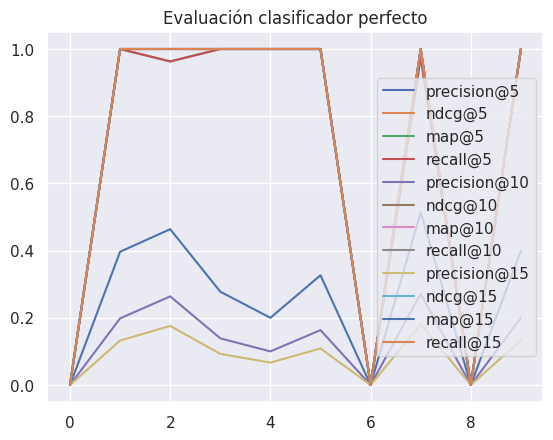

In [21]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [22]:
from tqdm.autonotebook import tqdm

In [23]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/485 [00:00<?, ?it/s]

Warning, empty test fold 0
Warning, empty test fold 1
Warning, empty test fold 2
Warning, empty test fold 3
Warning, empty test fold 4
Warning, empty test fold 5


Warning, empty test fold 6
Warning, empty test fold 7


Warning, empty test fold 13


Warning, empty test fold 17
Warning, empty test fold 18
Warning, empty test fold 19
Warning, empty test fold 20
Warning, empty test fold 21
Warning, empty test fold 22


Warning, empty test fold 24
Warning, empty test fold 25
Warning, empty test fold 27


Warning, empty test fold 30


Warning, empty test fold 33
Warning, empty test fold 34
Warning, empty test fold 35
Warning, empty test fold 36
Warning, empty test fold 37


Warning, empty test fold 39
Warning, empty test fold 40


Warning, empty test fold 43
Warning, empty test fold 44
Warning, empty test fold 45


Warning, empty test fold 48
Warning, empty test fold 50


Warning, empty test fold 51
Warning, empty test fold 53


Warning, empty test fold 57
Warning, empty test fold 59


Warning, empty test fold 60
Warning, empty test fold 61


Warning, empty test fold 64
Warning, empty test fold 65


Warning, empty test fold 68
Warning, empty test fold 69


Warning, empty test fold 71
Warning, empty test fold 72


Warning, empty test fold 75


Warning, empty test fold 78


Warning, empty test fold 81
Warning, empty test fold 82


Warning, empty test fold 95
Warning, empty test fold 96
Warning, empty test fold 97


Warning, empty test fold 103


Warning, empty test fold 106


Warning, empty test fold 110


Warning, empty test fold 113


Warning, empty test fold 117


Warning, empty test fold 120
Warning, empty test fold 121


Warning, empty test fold 123
Warning, empty test fold 124


Warning, empty test fold 127


Warning, empty test fold 134


Warning, empty test fold 141


Warning, empty test fold 145


Warning, empty test fold 151
Warning, empty test fold 152


Warning, empty test fold 155


Warning, empty test fold 161
Warning, empty test fold 162


Warning, empty test fold 169


Warning, empty test fold 173


Warning, empty test fold 180


Warning, empty test fold 186
Warning, empty test fold 187


Warning, empty test fold 190


Warning, empty test fold 202


Warning, empty test fold 214
Warning, empty test fold 215


Warning, empty test fold 224
Warning, empty test fold 225


Warning, empty test fold 232


Warning, empty test fold 239


Warning, empty test fold 245


Warning, empty test fold 247


Warning, empty test fold 256
Warning, empty test fold 257


Warning, empty test fold 263
Warning, empty test fold 264


Warning, empty test fold 266
Warning, empty test fold 267


Warning, empty test fold 268


Warning, empty test fold 270


Warning, empty test fold 277


Warning, empty test fold 285


Warning, empty test fold 287
Warning, empty test fold 288


Warning, empty test fold 291
Warning, empty test fold 292


Warning, empty test fold 293


Warning, empty test fold 295
Warning, empty test fold 296


Warning, empty test fold 297


Warning, empty test fold 299


Warning, empty test fold 303
Warning, empty test fold 304


Warning, empty test fold 305
Warning, empty test fold 306


Warning, empty test fold 308
Warning, empty test fold 309


Warning, empty test fold 310
Warning, empty test fold 311


Warning, empty test fold 312
Warning, empty test fold 313


Warning, empty test fold 314


Warning, empty test fold 316


Warning, empty test fold 323


Warning, empty test fold 329
Warning, empty test fold 330


Warning, empty test fold 372


Warning, empty test fold 383


Warning, empty test fold 387


Warning, empty test fold 393
Warning, empty test fold 394


Warning, empty test fold 395
Warning, empty test fold 396


Warning, empty test fold 397
Warning, empty test fold 398


Warning, empty test fold 399
Warning, empty test fold 400


Warning, empty test fold 401
Warning, empty test fold 402


Warning, empty test fold 403


Warning, empty test fold 467


Warning, empty test fold 470


Warning, empty test fold 481


Warning, empty test fold 484


In [24]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2020-11-18 20:56:32 2023-07-19 14:30:54


t0: 2020-11-20 00:00:00
t1: 2020-11-22 00:00:00
t-2: 2023-07-14 00:00:00
t-1: 2023-07-16 00:00:00


In [25]:
{ k:len(v) for k,v in metrics.items() }

{'t': 485,
 'precision@5': 485,
 'ndcg@5': 485,
 'map@5': 485,
 'recall@5': 485,
 'precision@10': 485,
 'ndcg@10': 485,
 'map@10': 485,
 'recall@10': 485,
 'precision@15': 485,
 'ndcg@15': 485,
 'map@15': 485,
 'recall@15': 485}

In [26]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2020-11-18 20:51:14')

Timestamp('2020-11-18 20:56:32')

,userID,itemID,timestamp,rating
9824,0xf3862af14cbb4d9b781e41a3d4d74e7c2cdb73e2,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 20:56:32,1
9823,0xba71dfe1801d125ba201e8bebf7f0b9764d4b19b,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 21:23:13,1
9822,0x042a135bd342910ad7f67bbda74e3fd4125d1272,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 21:23:55,1
9821,0x21f3ef56cd8bafd9448515e4508077c16ecc1f35,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 21:42:37,1
9820,0x506f92308f4d9a2f764d80c68ebc50830a2f7a11,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 21:45:10,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,title,description,start,end,votes_count
462,snapshot,Index Coop,index-coop.eth,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,QmR8dNJPcZTcmSP5g86iaGUiArs9DeYTEZkSf7Dg2hVavS,0xf3862af14cbb4d9b781e41a3d4d74e7c2cdb73e2,2020-11-18 20:51:14,[AAVE-1] Upgrades for seamless transition to A...,This proposal is for voting on Aave's proposal...,2020-11-18 16:00:00,2020-11-21 08:28:00,46
694,snapshot,Index Coop,index-coop.eth,eba9b4f9-ad65-5bb3-8e14-7ac51c6c3634,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,QmRw6FoXJRhm4WLaWVuRgsXhE7ZfWvAKY42E386ksugfUC,0xc95fdee19b74bc9588f4888fb0762e83cfef5d45,2020-12-06 06:10:07,[COMPOUND-30] COMP Contributor Grants,This proposal is for voting on Compound's prop...,2020-12-05 23:13:19,2020-12-08 19:32:10,82
252,snapshot,Index Coop,index-coop.eth,cc55a2f4-e982-544d-ba72-22913ed4e1ab,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,QmTdYHoyT5eLWSZduHkivVxs3Vree1EUQUYCk8uoW4Q1EA,0xc95fdee19b74bc9588f4888fb0762e83cfef5d45,2020-12-07 21:50:10,[COMPOUND-31] Adjusting Reserve Factors,This proposal is for voting on Compound's prop...,2020-12-07 21:48:18,2020-12-10 21:47:41,45
294,snapshot,Index Coop,index-coop.eth,36cb30a7-7532-598a-87f8-07c204455bd5,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,QmethJXKnCMd89wWBaxCBRcK2Hu8Dhx5E5AM7XeHEKsL1n,0xc95fdee19b74bc9588f4888fb0762e83cfef5d45,2020-12-11 21:20:11,[COMPOUND-32] Distribute COMP to Affected User...,This proposal is for voting on Compound's prop...,2020-12-11 21:17:20,2020-12-14 21:13:36,77
399,snapshot,Index Coop,index-coop.eth,0bcf5b7b-c874-51ce-974b-b8b098ce6409,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,QmSSZzLPbLpegBWfxPBTVAdvUZoXAL2V6Hi58YHEi6bemW,0x5dd5fc8761fe933bc58e5ab5be062dd836dfa801,2020-12-16 02:13:40,IIP-7 CoinShares Gold and Cryptoassets Index L...,## Simple Summary\n\nThe CoinShares Gold and C...,2020-12-16 20:00:00,2020-12-19 20:00:00,93


In [27]:
# Save the data
from pathlib import Path
from src.baseline import write_metrics_baseline

# pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_baseline(pd.DataFrame(metrics).set_index('t'), ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000
mean,0.213606,0.572480,0.532105,0.651913,0.116498,0.584839,0.543923,0.684323,0.078260,0.585640,0.544552,0.686326,0.238468,0.122640,0.709230
std,0.168127,0.404983,0.399221,0.444353,0.098116,0.404368,0.397269,0.451415,0.066996,0.404297,0.397116,0.452091,0.193803,0.104726,0.454534
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.200000,0.726174,0.618965,1.000000,0.100000,0.743714,0.651389,1.000000,0.066667,0.743714,0.651389,1.000000,0.200000,0.100000,1.000000
75%,0.327273,0.958992,0.942424,1.000000,0.180000,0.958992,0.942424,1.000000,0.120000,0.958992,0.942424,1.000000,0.376471,0.188235,1.000000
max,0.695238,1.000000,1.000000,1.000000,0.525000,1.000000,1.000000,1.000000,0.413333,1.000000,1.000000,1.000000,0.825000,0.620000,1.000000


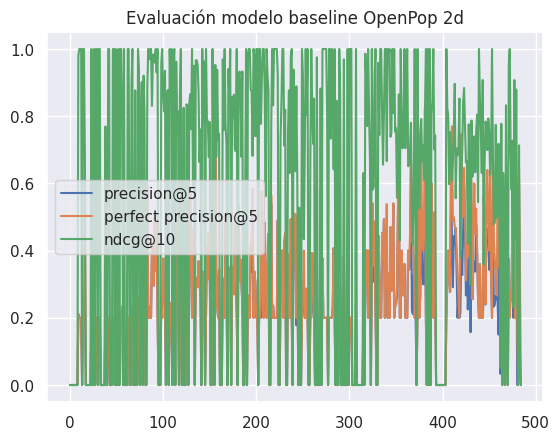

In [28]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [29]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.265556,0.406327,0.325855,0.539762,0.146778,0.434216,0.349188,0.646429,0.097852,0.434216,0.349188,0.646429,0.352556,0.192778,0.800000
std,0.260009,0.385951,0.352468,0.463299,0.128484,0.353467,0.344588,0.446646,0.085656,0.353467,0.344588,0.446646,0.243946,0.142586,0.421637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.012500,0.024178,0.015625,0.031250,0.043750,0.130283,0.072024,0.217262,0.029167,0.130283,0.072024,0.217262,0.200000,0.100000,1.000000
50%,0.200000,0.334296,0.175298,0.669643,0.100000,0.393442,0.208333,0.922619,0.066667,0.393442,0.208333,0.922619,0.385000,0.192500,1.000000
75%,0.529167,0.769607,0.573026,0.983333,0.264583,0.723746,0.620268,1.000000,0.176389,0.723746,0.620268,1.000000,0.554167,0.313194,1.000000
max,0.600000,0.907732,0.875000,1.000000,0.340000,0.907732,0.875000,1.000000,0.226667,0.907732,0.875000,1.000000,0.650000,0.400000,1.000000


,t,model,variable,value
0,2020-11-19 23:51:47,openpop,precision@5,0.000000
1,2020-11-20 23:05:39,openpop,precision@5,0.000000
2,2020-11-20 23:05:39,openpop,precision@5,0.000000
3,2020-11-20 23:05:39,openpop,precision@5,0.000000
4,2020-11-20 23:05:39,openpop,precision@5,0.000000
...,...,...,...,...
1935,2023-07-07 17:46:19,perfect,recall@5,1.000000
1936,2023-07-08 11:30:09,perfect,recall@5,0.000000
1937,2023-07-11 23:58:22,perfect,recall@5,0.886905
1938,2023-07-13 23:11:02,perfect,recall@5,1.000000


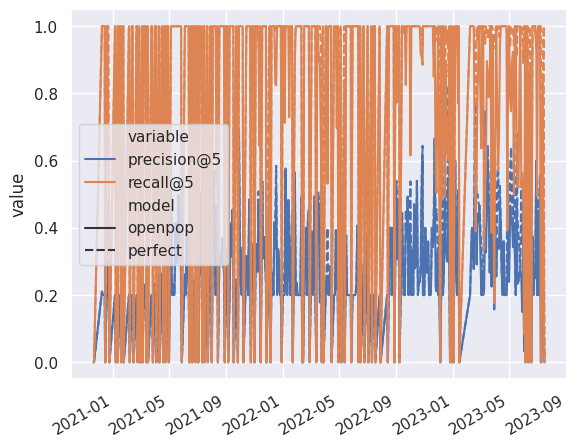

In [30]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

In [31]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2020-11-19 23:51:47,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
1,2020-11-20 23:05:39,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
2,2020-11-20 23:05:39,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
3,2020-11-20 23:05:39,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
4,2020-11-20 23:05:39,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,2023-07-07 17:46:19,0.20,1.0,1.000000,1.000000,0.10,1.0,1.0,1.0,0.066667,1.0,1.0,1.0,perfect
481,2023-07-08 11:30:09,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,perfect
482,2023-07-11 23:58:22,0.65,1.0,0.886905,0.886905,0.40,1.0,1.0,1.0,0.266667,1.0,1.0,1.0,perfect
483,2023-07-13 23:11:02,0.32,1.0,1.000000,1.000000,0.16,1.0,1.0,1.0,0.106667,1.0,1.0,1.0,perfect


Cannot show ipywidgets in text

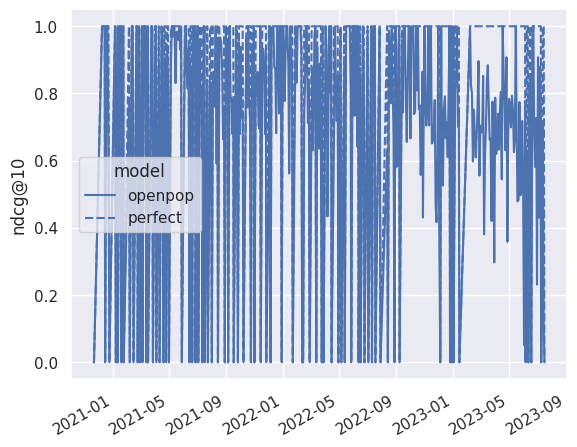

In [32]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [33]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.396610,1.0,1.000000,1.000000,0.198305,1.0,1.0,1.0,0.132203,1.0,1.0,1.0
2,0.463768,1.0,0.962963,0.962963,0.263768,1.0,1.0,1.0,0.175845,1.0,1.0,1.0
3,0.277778,1.0,1.000000,1.000000,0.138889,1.0,1.0,1.0,0.092593,1.0,1.0,1.0
4,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0
5,0.326667,1.0,1.000000,1.000000,0.163333,1.0,1.0,1.0,0.108889,1.0,1.0,1.0
6,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
7,0.514286,1.0,0.976190,0.976190,0.271429,1.0,1.0,1.0,0.180952,1.0,1.0,1.0
8,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
9,0.400000,1.0,1.000000,1.000000,0.200000,1.0,1.0,1.0,0.133333,1.0,1.0,1.0


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000
mean,0.238468,0.709278,0.704803,0.704803,0.122640,0.709278,0.709230,0.709230,0.081795,0.709278,0.709278,0.709278
std,0.193803,0.454564,0.452155,0.452155,0.104726,0.454564,0.454534,0.454534,0.069891,0.454564,0.454564,0.454564
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.200000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.000000
75%,0.376471,1.000000,1.000000,1.000000,0.188235,1.000000,1.000000,1.000000,0.125490,1.000000,1.000000,1.000000
max,0.825000,1.000000,1.000000,1.000000,0.620000,1.000000,1.000000,1.000000,0.413333,1.000000,1.000000,1.000000


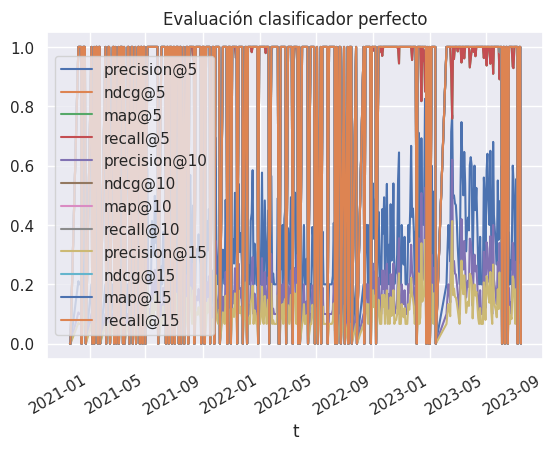

In [34]:
from src.baseline import write_metrics_perfect

pmdf = pd.DataFrame(perfectmetrics).set_index('t')

# pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_perfect(pmdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [35]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 485 folds
From 2020-11-18 20:56:32 to 2023-07-19 14:30:54


,train,test,open,test users,test vpv,test vpp
count,485.000000,485.000000,485.000000,485.000000,351.000000,351.000000
mean,13863.701031,27.985567,2.529897,17.232990,0.688870,13.307622
std,7414.478217,68.911893,2.771914,62.449859,0.254509,71.331566
min,41.000000,0.000000,0.000000,0.000000,0.165354,0.384615
25%,7816.000000,0.000000,0.000000,0.000000,0.460499,2.500000
50%,16215.000000,13.000000,2.000000,9.000000,0.666667,6.000000
75%,19678.000000,35.000000,4.000000,20.000000,1.000000,12.000000
max,24024.000000,1326.000000,16.000000,1326.000000,1.000000,1326.000000


In [36]:
fold_len

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
0,2020-11-20,41,5,1,5,1.000,5.000000,2020-11-20 14:13:15,2020-11-20 23:05:39
1,2020-11-22,46,0,0,0,NaN,NaN,NaT,NaT
2,2020-11-24,46,0,0,0,NaN,NaN,NaT,NaT
3,2020-11-26,46,0,0,0,NaN,NaN,NaT,NaT
4,2020-11-28,46,0,0,0,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...
480,2023-07-08,23987,1,3,1,1.000,1.000000,2023-07-08 11:30:09,2023-07-08 11:30:09
481,2023-07-10,23988,0,0,0,NaN,NaN,NaT,NaT
482,2023-07-12,23999,16,7,4,0.250,0.571429,2023-07-12 07:54:12,2023-07-13 23:11:02
483,2023-07-14,24016,8,5,5,0.625,1.666667,2023-07-14 00:31:12,2023-07-15 11:49:15


In [37]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10 # obviously, to test @10, we need 10 open proposals
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10 + 1

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['open'] >= MIN_OPEN)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 16 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window


In [38]:
fold_len['min2'] = fold_len['min'] & (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min2'].sum(), "folds that could be used")
fold_len['min2_window'] = fold_len.rolling(MIN_FOLDS)['min2'].sum() >= MIN_FOLDS
fold_len[fold_len['min2_window']].tail(20)

There are 13 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window,min2,min2_window


            train  test  i
t                         
2020-11-20     41     5  0
2020-11-22     46     0  1
2020-11-24     46     0  2
2020-11-26     46     0  3
2020-11-28     46     0  4
2020-11-30     46     0  5
2020-12-02     46     0  6
2020-12-04     46     0  7
2020-12-06     46    71  8
2020-12-08    118    46  9


Cannot show ipywidgets in text

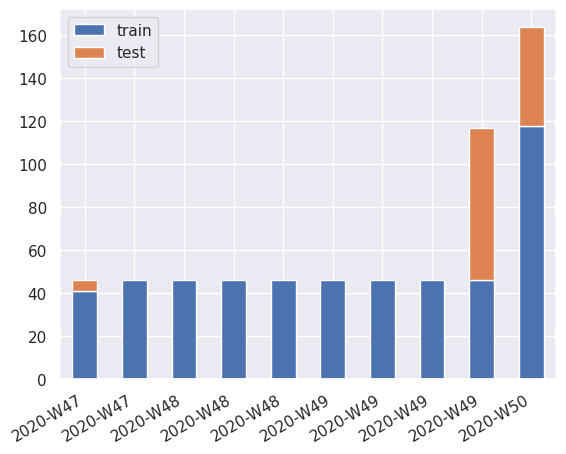

In [39]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

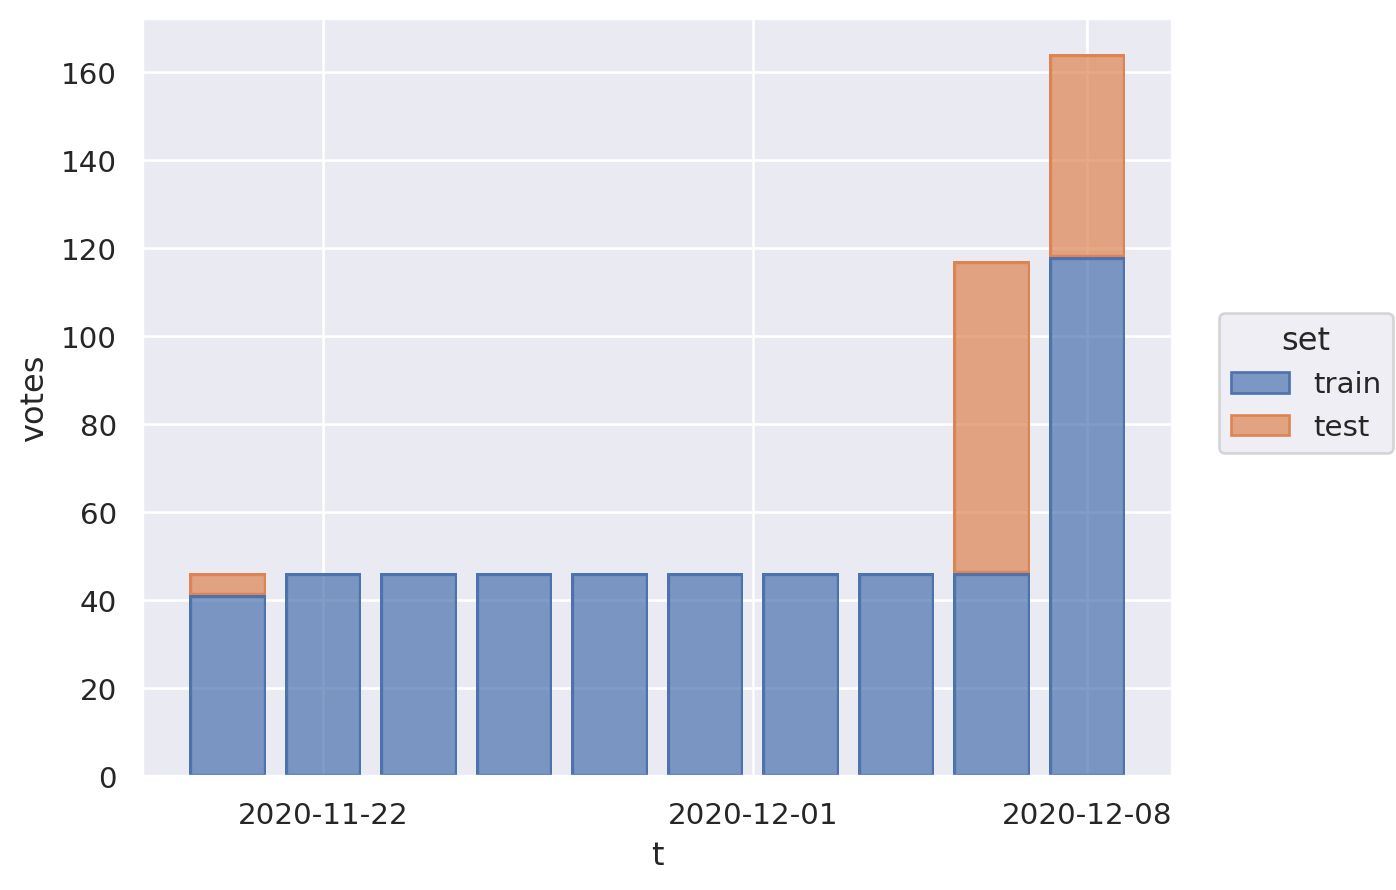

In [40]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())